<a href="https://colab.research.google.com/github/4LanCrane/4LanCrane/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import array, col,size,lit,array_except,explode,avg
from pyspark.ml.fpm import FPGrowth
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Colab Notebooks/DiseaseAndSymptoms.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# function for creating a spark session
def create_spark_session(app_name="HealthData"):
    return SparkSession.builder.appName(app_name).getOrCreate()

# function for creating a dataframe
def create_Dataframe(spark,file_path):
    return spark.read.csv(file_path, header=True, inferSchema=True)

# extracts symptoms colums from dataframe, resource used for code https://www.kaggle.com/code/megan3/market-basket-analysis-using-pyspark
def extract_symptoms_column(df):
    symptom_columns = [col_name for col_name in df.columns if col_name != 'Disease']
    df = df.withColumn('Symptoms', array(*symptom_columns))
    return df.select('Disease', 'Symptoms')

# runs fpGrowth and returns model
def run_fp_growth(df_aggregated,items_col_value, minSupport, minConfidence):
    fp = FPGrowth(itemsCol=items_col_value, minSupport=minSupport, minConfidence=minConfidence)
    model = fp.fit(df_aggregated)
    return model

# prints the number of distinct values
def countDistinct(df, columnName,colTitle):
  print("Number of unique " + colTitle + "=",df.select(columnName).distinct().count())

# shows only results with a single prediction
def show_single_prediction(model, df_aggregated, num_rows=100):
    single_prediction = model.transform(df_aggregated).filter(size(col("prediction")) == 1)
    single_prediction.show(num_rows, truncate=False)
    return single_prediction

# splits each symptom into a new row
def explode_symptoms_column(df, symptoms_col="Symptoms"):
    exploded_df = df.select(explode(col(symptoms_col)).alias("Symptom"))
    return exploded_df

# removes all nuls from the symptoms array,  resource used for code https://www.kaggle.com/code/megan3/market-basket-analysis-using-pyspark
def remove_null_symptoms(df, symptoms_col="Symptoms"):
    cleaned_df = df.select(
        "Disease",
        array_except(col(symptoms_col), array(lit(None))).alias(symptoms_col)
    )
    return cleaned_df


def calculate_symptom_percentages(exploded_df):
    total_symptoms = exploded_df.count()

    symptom_counts = exploded_df.groupBy("Symptom").count()

    symptom_counts = symptom_counts.withColumn(
        "percentage", (col("count") / total_symptoms) * 100
    )

    return symptom_counts



def plot_symptom_percentages(df_pd, top_n=None):
    if top_n:
        df_pd = df_pd.head(top_n)

    plt.figure(figsize=(14, 8))
    plt.bar(df_pd["Symptom"], df_pd["percentage"], color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel("Symptom")
    plt.ylabel("Percentage (%)")
    plt.title("Percentage of Each Symptom in Dataset")
    plt.tight_layout()
    plt.show()


def calculate_average_symptoms(df, symptoms_col="Symptoms"):
    df_with_countsForEach = df.withColumn("num_symptoms", size(col(symptoms_col)))
    avg_symptoms = df_with_countsForEach.select(avg("num_symptoms")).first()[0]
    return avg_symptoms

In [31]:
spark = create_spark_session()
df = create_Dataframe(spark, file_path)


In [32]:
numOfRecords = df.count()
print("Number of records = ", numOfRecords)

Number of records =  4920


Combines multiple symptom colums into one Symptom colum

In [33]:
df = extract_symptoms_column(df)

In [34]:
df.show(10,False)

+----------------+------------------------------------------------------------------------------------------------------------------------------------------------+
|Disease         |Symptoms                                                                                                                                        |
+----------------+------------------------------------------------------------------------------------------------------------------------------------------------+
|Fungal infection|[itching,  skin_rash,  nodal_skin_eruptions,  dischromic _patches, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]|
|Fungal infection|[ skin_rash,  nodal_skin_eruptions,  dischromic _patches, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]   |
|Fungal infection|[itching,  nodal_skin_eruptions,  dischromic _patches, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]      |
|Fungal infectio

Seprates each Symptom into a new row

In [35]:
exploded_df = explode_symptoms_column(df)
exploded_df.groupBy("Symptom").count().orderBy("count", ascending=False).show(10)

+------------------+-----+
|           Symptom|count|
+------------------+-----+
|              NULL|46992|
|           fatigue| 1932|
|          vomiting| 1914|
|        high_fever| 1362|
|  loss_of_appetite| 1152|
|            nausea| 1146|
|          headache| 1134|
|    abdominal_pain| 1032|
|    yellowish_skin|  912|
| yellowing_of_eyes|  816|
+------------------+-----+
only showing top 10 rows



Calulate the percentage each Symptom represents in the dataset

+------------------+-----+------------------+
|           Symptom|count|        percentage|
+------------------+-----+------------------+
|              NULL|46992|56.183644189383074|
|           fatigue| 1932| 2.309899569583931|
|          vomiting| 1914|2.2883787661406028|
|        high_fever| 1362|1.6284074605451937|
|  loss_of_appetite| 1152|1.3773314203730271|
|            nausea| 1146| 1.370157819225251|
|          headache| 1134|1.3558106169296986|
|    abdominal_pain| 1032|1.2338593974175036|
|    yellowish_skin|  912|1.0903873744619799|
| yellowing_of_eyes|  816| 0.975609756097561|
+------------------+-----+------------------+
only showing top 10 rows



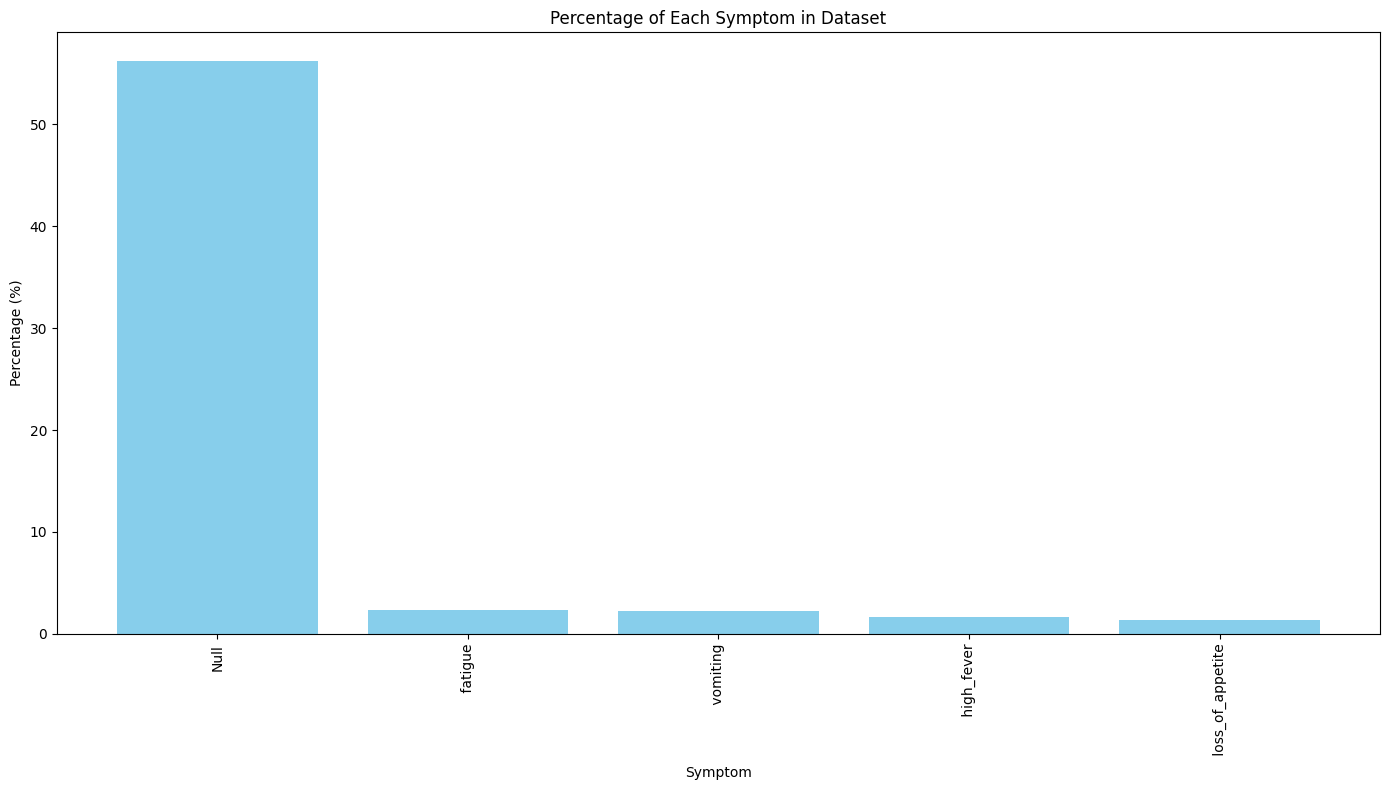

In [36]:
symptoms_percent_withNull = calculate_symptom_percentages(exploded_df).orderBy("percentage", ascending=False)
symptoms_percent_withNull.show(10)
symptoms_percent_withNull_pd = symptoms_percent_withNull.toPandas()
symptoms_percent_withNull_pd['Symptom'] = symptoms_percent_withNull_pd['Symptom'].fillna('Null')
plot_symptom_percentages(symptoms_percent_withNull_pd, top_n=5)

Remove all null values from Symptoms


In [37]:
df_aggregated = remove_null_symptoms(df)
df_aggregated.show(3,False)

+----------------+------------------------------------------------------------------+
|Disease         |Symptoms                                                          |
+----------------+------------------------------------------------------------------+
|Fungal infection|[itching,  skin_rash,  nodal_skin_eruptions,  dischromic _patches]|
|Fungal infection|[ skin_rash,  nodal_skin_eruptions,  dischromic _patches]         |
|Fungal infection|[itching,  nodal_skin_eruptions,  dischromic _patches]            |
+----------------+------------------------------------------------------------------+
only showing top 3 rows



Calulate the average number of symptoms per disease

In [38]:
print("Average number of symptoms per disease:", calculate_average_symptoms(df_aggregated))

Average number of symptoms per disease: 7.4487804878048784


In [39]:
countDistinct(df_aggregated,"Disease","diseases")
countDistinct(df_aggregated,"Symptoms","symptoms")

Number of unique diseases= 41
Number of unique symptoms= 304


+------------------+-----+------------------+
|           Symptom|count|        percentage|
+------------------+-----+------------------+
|           fatigue| 1932|  5.27177472167649|
|          vomiting| 1914| 5.222658808120498|
|        high_fever| 1362|3.7164374590700717|
|  loss_of_appetite| 1152| 3.143418467583497|
|            nausea| 1146| 3.127046496398166|
|          headache| 1134| 3.094302554027505|
|    abdominal_pain| 1032|2.8159790438768826|
|    yellowish_skin|  912|2.4885396201702688|
| yellowing_of_eyes|  816| 2.226588081204977|
|            chills|  798| 2.177472167648985|
+------------------+-----+------------------+
only showing top 10 rows



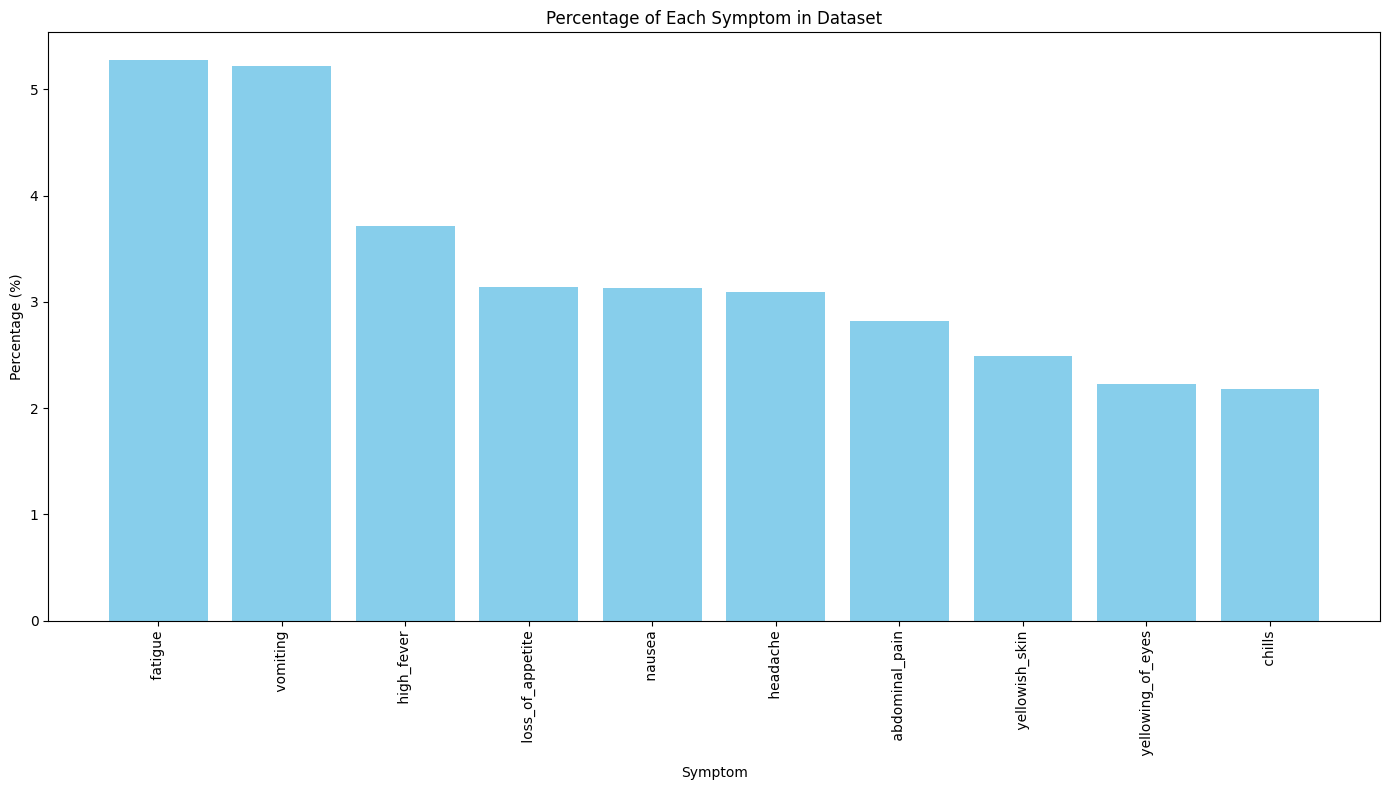

In [40]:
symptoms_percent_withoutNull = calculate_symptom_percentages(explode_symptoms_column(df_aggregated)).orderBy("percentage", ascending=False)
symptoms_percent_withoutNull.show(10)
plot_symptom_percentages(symptoms_percent_withoutNull.toPandas(), top_n=10)

In [41]:
model = run_fp_growth(df_aggregated, "Symptoms", 0.05, 0.8)
model.associationRules.show(10, False)

+-----------------------------------------------------------------------------------------------+-------------------+------------------+------------------+--------------------+
|antecedent                                                                                     |consequent         |confidence        |lift              |support             |
+-----------------------------------------------------------------------------------------------+-------------------+------------------+------------------+--------------------+
|[ chills,  headache,  fatigue]                                                                 |[ high_fever]      |0.9629629629629629|3.4785446239190727|0.06341463414634146 |
|[ joint_pain,  yellowing_of_eyes,  nausea,  loss_of_appetite,  vomiting]                       |[ yellowish_skin]  |0.9375            |5.057565789473684 |0.054878048780487805|
|[ joint_pain,  yellowing_of_eyes,  nausea,  loss_of_appetite,  vomiting]                       |[ abdominal_pain] 

Now increase the minsupport and minconfidence

In [42]:
model = run_fp_growth(df_aggregated, "Symptoms", 0.06, 0.8)

Show the association Rules

In [43]:
model.associationRules.orderBy("confidence", ascending=False).show(40, False)

+------------------------------------------------------------------+--------------------+------------------+------------------+-------------------+
|antecedent                                                        |consequent          |confidence        |lift              |support            |
+------------------------------------------------------------------+--------------------+------------------+------------------+-------------------+
|[ phlegm,  cough,  malaise]                                       |[ chest_pain]       |1.0               |7.06896551724138  |0.06585365853658537|
|[ cough,  chills]                                                 |[ chest_pain]       |1.0               |7.06896551724138  |0.06585365853658537|
|[ phlegm,  cough,  malaise,  chills]                              |[ chest_pain]       |1.0               |7.06896551724138  |0.06219512195121951|
|[ phlegm,  cough,  fatigue]                                       |[ chest_pain]       |1.0               |7.06

Check that prediction is not empty and show 100 results where there is only one prediction given


In [44]:
show_single_prediction(model,df_aggregated, 100)

+----------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|Disease                     |Symptoms                                                                                                                                                                                                                              |prediction          |
+----------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|Allergy                     |[ continuous_sneezing,  shivering,  chills,  watering_from_eyes]                                                         

DataFrame[Disease: string, Symptoms: array<string>, prediction: array<string>]

In [45]:
filterd = model.transform(df_aggregated).filter(size(col("Prediction")) > 0 )
filterd.orderBy("Disease", ascending=True)
filterd.show(400, False)

+---------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------+
|Disease                                |Symptoms                                                                                                                                                                                                                              |prediction                                      |
+---------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------+
|Allergy                          